# Getting Hector's data for comparison with SPT prediction

We wish to compare the SPT bispectrum used by Hector to what Pierre's code predicts. This notebook contains the scripts carried out by NK in order to perform this comparison. We begin by extracting the triangles computed by Hector and saving them. These will be fed into Pierre's code for the bispectrum monopole.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

hector_bisp = np.loadtxt('Bispectrum_SPTkernels_P0kmax_000_P0kmin_000_P2kmax_000_P2kmin_000_P4kmax_000_P4kmin_000_B0kmax_015_B0kmin_003_nowindow.txt')


In [2]:
triangles = hector_bisp[:,:3]
np.savetxt('hector_triangles.dat', triangles)

Next we need to compute the linear power spectrum that will be used to compute the bispectrum in Pierre's code. We compute this using _classy_, the Python wrapper for the CLASS Boltzmann code. In the following lines we fix the cosmology to the fiducial one used in the analysis of Gil-Marín et al (1606.00439), which is

$$(\Omega_\Lambda, \Omega_m, \Omega_b, \sigma_8, h, n_s) = (0.69, 0.31, 0.049, 0.8475, 0.6711, 0.9624)$$

we also make sure that the k range we compute the spectrum in (at $z=0.57$) corresponds to at least $k_{min}/h < 10^{-4}$ and $k_{max}/h > 20$. We also tuned $\ln (10^{10} A_s)$ such that $\sigma_8$ matches the fiducial value given here. 

In [3]:
from classy import Class 
z_pk = 0.57
mb_ratio = 0.15629104798100547336034

lnA_s = 2.9195
n_s = 0.9624
h = 0.6711

Omega_cdm = 0.31

Omega_b = 0.049


params = {
	'output': 'mPk',
	'z_pk': 0.55,
	'Omega_cdm': Omega_cdm,
	'Omega_b': Omega_b,
	'n_s': n_s,
	'P_k_max_h/Mpc': 22,
	'h': h,
	'ln10^{10}A_s': lnA_s,
	'headers': 'no',
	'format': 'camb'
}
cosmo = Class()
cosmo.set(params)
cosmo.compute()


kvals = np.logspace(-4.5, 1.13, 116)
pk = []
for k in kvals:
	pk.append(cosmo.pk(k, z_pk))
    



In [4]:

pk_array = [kvals/h, pk]
pk = np.array(pk)
# plt.loglog(kvals/h, pk)

In [5]:
pk_array = np.array(pk_array)

In [6]:
np.savetxt('hector_fid_class.dat', pk_array.transpose())

Now that we've saved the linear power spectrum, we ran Pierre's code using it. We also modified Pierre's code such that the value of the linear growth parameter $f$ is fixed to Hector's best value of 

$f = 0.707464$

We also ran the code with his best values for the AP parameters, 

$\alpha_\perp = 1.121754$ and $\alpha_\parallel = 0.927504$

and a shot-noise value of $\bar{n} = 4.5 \times 10^{-4}$ as shown in table 1 of Gil-Marín et al. Finally, we need to convert the values of bias parameters from Hector's basis to our basis of descendants. The relationships are (following Pierre's mathematica notebook to confirm our raw bispectra were the same)


$b_1 = c_1$

$b_2 = c_1 + \frac{7}{4} c_4$

$b_4 = c_2 - \frac{17}{12} c_4$

where $b_i$ are our bias parameters and $c_i$ are Hector's. He only gave us values of $b_1$ and $b_2$ but this is because his analysis assumes local Lagrangian bias which restricts his $c_4$ to be 
$c_4 = -\frac{4}{7} (c_1 - 1)$

he also assumes no deviation from Poissonian shot-noise which means our stochastic bias parameters $b_11 = b_8 = 1$. The following cell implements all these statements with the bispectrum monopole that came from running Pierre's code. We additionally note that the difference between the value of $f$ for our fiducial cosmology and Hector's best-fit was 

$$\frac{f_{fid}}{f_{best}} = \frac{0.812201}{0.707464} \approx 1.1480$$


In [7]:
#bispectrum bias terms
def bispectrum_compute(terms, coefs):
    b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11 = coefs
    bval = np.array([1.,b1,b2,b4,b1*b11,b1**2,b1*b2,b1*b4,b1**3,b1**2*b2,b1**2*b4,b8**2])
    return np.dot(bval, terms.transpose())

#b1 and b2 from best fit table, b4 from local lagrangian bias assumption
b1_hector = 1.870858
b2_hector = 1.603323
b4_hector = -4./7. * (b1_hector - 1.)

#From hector bias terms to BoD bias terms following Pierre's notebook
bshape = np.zeros(11)
# bshape[0] = b1_hector
bshape[9] = 1.
bshape[-1] = 1.
bshape[1] = b1_hector + 7./4. *b4_hector
# bshape[1] = b2_hector
bshape[3] = b2_hector/2. - 17./12. *b4_hector
# bshape[3] = b4_hector

nick_bisp_raw = np.loadtxt('hector_bispectrum_monopole_nbar.dat')

In [8]:
nick_bisp = bispectrum_compute(nick_bisp_raw[:,3:], bshape)

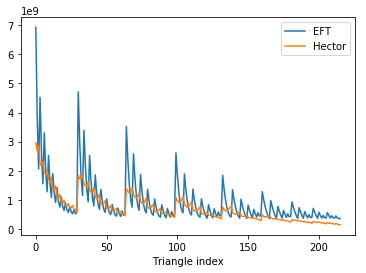

In [9]:
hec = hector_bisp[:,-1].transpose()
plt.plot(nick_bisp, label='EFT')
plt.plot(hec, label='Hector')
plt.xlabel('Triangle index')
plt.legend()

There seems to be some difference between our prediction and Hector's, and no factor of 4pi seems to fix it. The ratio of the results is:

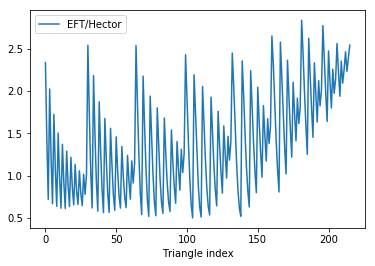

In [10]:
plt.plot(nick_bisp/hec, label='EFT/Hector')
plt.xlabel('Triangle index')
plt.legend()

Note our power spectrum doesn't have the window function of BOSS applied to it, perhaps this could explain the differences we are observing. In the following cells we implement this difference by expanding the linear spectrum in multipoles, applying the window function and then reconstructing the spectrum before feeding it into Pierre's code. 

In [11]:
#processing the input power spectrum with the window function
#functions used are from zbetools.py and the other window function scripts eventually
import WindowFFTlog

def Classtomultipoles(setk,Pkclass,Om,zpk):
    kmulti=np.concatenate([setk,setk,setk])
#     f=fN(Om,1./(+zpk))
    #Setting the value of f as fixed according to Hector's best fit value
    f = 0.707464
    P0k=(1 + (2*f)/3. + f**2/5.)*Pkclass
    P2k=((4*f*(7 + 3*f))/21.)*Pkclass
    P4k=((8*f**2)/35.)*Pkclass
    return np.array([kmulti,np.concatenate([P0k,P2k,P4k])])

def multipolestoClass(kmulti,Pmulti,Om,zpk):
#     kclass=kmulti[:len(kmulti)/3]
    kclass = kmulti
    P0k=Pmulti[:len(kmulti)/3]
    P2k=Pmulti[len(kmulti)/3:2*len(kmulti)/3]
    P4k=Pmulti[2*len(kmulti)/3:3*len(kmulti)/3]
    #f=fN(Om,1./(+zpk))
    #fixing f to Hector's best fit value 
    f = 0.707464
    Pkclass=P0k/(1 + (2*f)/3. + f**2/5.)
    return np.array([kclass,Pkclass])

dataQ = np.loadtxt('/home/nick/Spring18Rotation/EFTofBOSS/input/Window_functions/dataQ_NGC.txt').transpose()

multipoles = Classtomultipoles(kvals/h, pk, 0.31, 0.57)

windowed_multipoles = WindowFFTlog.transformQ(multipoles[1], kvals, kvals, dataQ, extrap=False)

rebuilt_spectra = multipolestoClass(kvals, windowed_multipoles, 0.31, 0.57)

I will run the comparison on monday once I better understand the multipolestoClass function. I've sent messages to Pierre about it and am waiting for his response. 